In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from transforms import *
from FISTA_RMS import *
from rm_clean import *
from matplotlib import rc
from performance import *
import pywt
from thresholds import softThreshold
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [19]:
#Constants and scales for lambda2 and phi
c = 2.99792458e8
m = 126 #Number of channels
w_min = 3.6 #wavelength start cm
w_max = 50.0 #wavelength end cm

w2_min = (w_min/100.0)*(w_min/100.0) #Min lambda2 in m^2
w2_max = (w_max/100.0)*(w_max/100.0) #Max lambda2 in m^2

lambda2_ref = (w2_max+w2_min)/2 #Reference lambda2 -> lambda2_0
delta_lambda2 = (w2_max-w2_min)/(m-1) #delta lambda2

lambda2 = np.arange(w2_min, w2_max, delta_lambda2) #lambda2 sampling

delta_phi = 2*np.sqrt(3)/(w2_max-w2_min) # delta phi as Brentjens et al - FWHM of the main peak of the RMSF

phi_max = np.sqrt(3)/delta_lambda2 #Phi max as Brentjens et al

times = 4

phi_r = delta_phi/times #The resolution is 4 times less than the FWHM of the main peak of the RMSF

temp = np.int(np.floor(2*phi_max/phi_r)) #we calculate the number of grid points N
n = temp-np.mod(temp,32) #We make sure that n is a even number to use the wavelet transform

phi_r = 2*phi_max/n; 
phi = phi_r*np.arange(-(n/2),(n/2), 1) #phi sampling

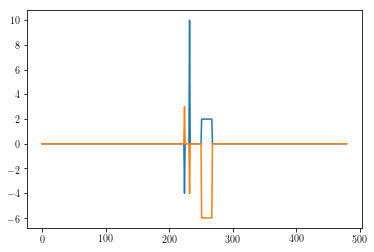

In [107]:
#Constructing simulated thin and thick sources
#2 complex thin sources -> spikes and 1 thick source
sources_F = [-4+1j*3, 10-1j*4] #Jy
sources_F3 = 2-1j*6 #Jy
#Positions in phi
pos_F = [-58, -30] #spikes position
pos_F3 = [41,100] #Thick source interval

F = np.zeros(n) + 1j*np.zeros(n) # We create our Faraday dispersion function
W = np.ones(m) # We assume that our observation windows has uniform weights for the m channels
K = 1/np.sum(W); #Normalising constant

#We create our spikes and thick sources in F
for i in range(0,len(sources_F)):
    ps_idx = (np.abs(phi-pos_F[i])).argmin()
    F[ps_idx] = sources_F[i]
    
ps_idx_1 = (np.abs(phi-pos_F3[0])).argmin()
ps_idx_2 = (np.abs(phi-pos_F3[1])).argmin()
F[ps_idx_1:ps_idx_2] = sources_F3
plt.plot(F.real)
plt.plot(F.imag)
#plt.plot(np.abs(F))

In [94]:
#We go to lambda2 space - This is not used, is only to plot it if you want
P = form_P(F, phi, lambda2, 0, m)
#We get the RMSF
R = form_R(K, W, phi, lambda2, lambda2_ref, n)
#We get the complex polarized emission
P_meas = form_P_meas(W, F, phi, lambda2, 0, m)
#We get the dirty Faraday dispersion function
F_dirty = form_F_dirty(K, P_meas, phi, lambda2, 0, n)/K/n

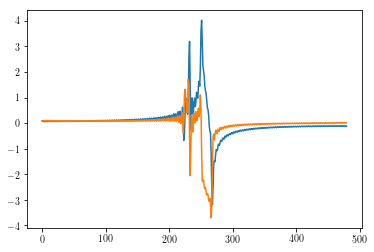

In [108]:
plt.plot(F_dirty.real)
plt.plot(F_dirty.imag)
#plt.plot(np.abs(F_dirty))

496
496
8


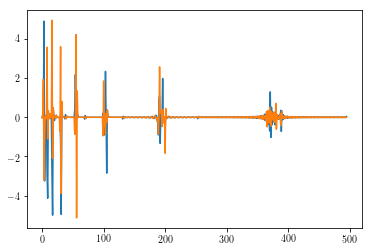

In [137]:
haar = pywt.Wavelet('db2')

re_coeffs = pywt.wavedec(F_dirty.real, haar, level=None, mode='zpd')
im_coeffs = pywt.wavedec(F_dirty.imag, haar, level=None, mode='zpd')

k = 0
vec = 0
for level in re_coeffs:
    vec += len(level)
    k += np.count_nonzero(level)
print(k)
print(vec)
print(len(re_coeffs))

plot_re_coeffs = np.concatenate(re_coeffs, axis=0 )
plot_im_coeffs = np.concatenate(im_coeffs, axis=0 )

plt.plot(plot_re_coeffs)
plt.plot(plot_im_coeffs)

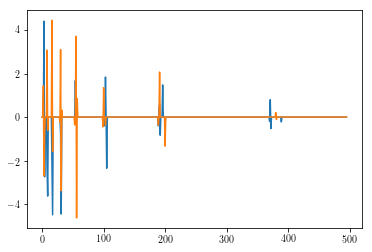

In [138]:
thres_re = []
thres_im = []
for level in re_coeffs:
    thres_re.append(softThreshold(level,0.5))
    
for level in im_coeffs:
    thres_im.append(softThreshold(level,0.5))
#print(thres_re)  
plot_re_coeffs = np.concatenate(thres_re, axis=0 )
plot_im_coeffs = np.concatenate(thres_im, axis=0 )
plt.plot(plot_re_coeffs)
plt.plot(plot_im_coeffs)

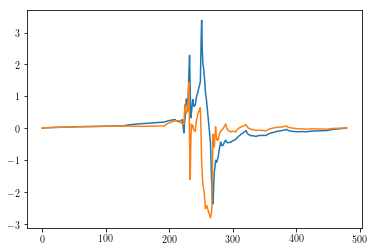

In [139]:
recon_real = pywt.waverec(thres_re, 'db2', mode='zpd')
recon_imag = pywt.waverec(thres_im, 'db2', mode='zpd')

recon = recon_real + 1j*recon_imag

#plt.plot(np.abs(recon_real))
plt.plot(recon.real)
plt.plot(recon.imag)
#plt.plot(np.abs(recon))

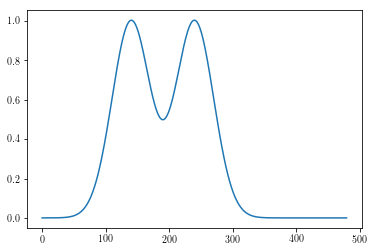

In [47]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x_values = np.arange(-(n/2),(n/2), 1)

F.real = gaussian(x_values, -100, 30) + gaussian(x_values, 0, 30)
F.imag = gaussian(x_values, 0, 50)

plt.plot(F.real)

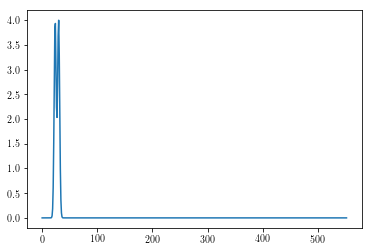

In [14]:
db10 = pywt.Wavelet('db10')
re_coeffs = pywt.wavedec(F.real, db10, mode='zpd')
im_coeffs = pywt.wavedec(F.imag, db10, mode='zpd')

plot_re_coeffs = np.concatenate(re_coeffs, axis=0 )

plt.plot(plot_re_coeffs)

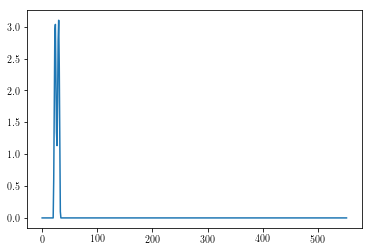

In [15]:
thres_re_coeffs = []

for k in re_coeffs:
    thres_k = pywt.threshold(k, 0.9, 'soft')
    thres_re_coeffs.append(thres_k)

plot_thres_re = np.concatenate(thres_re_coeffs, axis=0)


plt.plot(plot_thres_re)

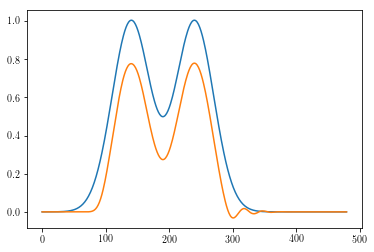

In [18]:
recon_real = pywt.waverec(thres_re_coeffs, 'db10', mode='zpd')
plt.plot(F.real)
plt.plot(recon_real)